# **Creating** your own dataset from Google Images¶


https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson2-download.ipynb


In [0]:
from fastai.vision import *


##    **Définir les classes** 
##    **Telecharger leurs images**


In [0]:
#definir les classes
classes = ['canard_laque_pekinois','kebab','osso_bucco']

In [0]:
#definir
folder = 'canard_laque_pekinois'
file = 'canard_laque_pekinois.csv'

In [0]:
#instancier
path = Path('data/plats')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [5]:
path.ls()

[PosixPath('data/plats/canard_laque_pekinois')]

In [0]:
#telecharger
download_images(path/file, dest, max_pics=200)

In [0]:
#definir
folder = 'kebab'
file = 'kebab.csv'

In [0]:
#instancier
path = Path('data/plats')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [11]:
path.ls()

[PosixPath('data/plats/kebab.csv'),
 PosixPath('data/plats/osso_bucco.csv'),
 PosixPath('data/plats/kebab'),
 PosixPath('data/plats/canard_laque_pekinois'),
 PosixPath('data/plats/canard_laque_pekinois.csv')]

In [0]:
#telecharger
download_images(path/file, dest, max_pics=200)

In [0]:
#definir
folder = 'osso_bucco'
file = 'osso_bucco.csv'

In [0]:
#instancier
path = Path('data/plats')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [15]:
path.ls()

[PosixPath('data/plats/kebab.csv'),
 PosixPath('data/plats/osso_bucco'),
 PosixPath('data/plats/osso_bucco.csv'),
 PosixPath('data/plats/kebab'),
 PosixPath('data/plats/canard_laque_pekinois'),
 PosixPath('data/plats/canard_laque_pekinois.csv')]

In [0]:
#telecharger
download_images(path/file, dest, max_pics=200)

In [0]:
#remove any images that can't be opened
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

## **View data**

In [0]:
#creation d'un objet ImageDatabunch (databunch)
#normalisation de toutes les images
#préparation des classes avec un train et un valid
#en gros le split train/test de sklearn
np.random.seed(43)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [19]:
#checker les classes
data.classes

['canard_laque_pekinois', 'kebab', 'osso_bucco']

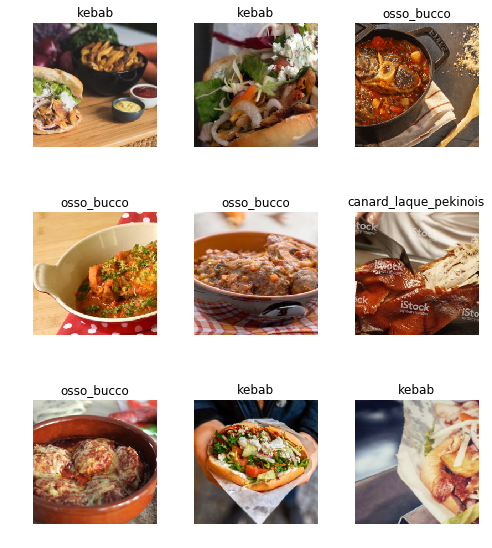

In [20]:
#checker les images
data.show_batch(rows=3, figsize=(7,8))

In [21]:
#checker les noms des classes
#checker le nombre de classes
#checker la longueur du train
#checker la longueur du test (valid) 
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['canard_laque_pekinois', 'kebab', 'osso_bucco'], 3, 459, 114)

## **Train model**

In [22]:
#instancier le model resnet34 sur data
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 104MB/s] 


In [23]:
#train le model sur 4 cycles
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.757604,0.568473,0.166667,00:10
1,1.113639,0.630114,0.166667,00:08
2,0.831350,0.594543,0.149123,00:08
3,0.668502,0.568337,0.149123,00:08


In [0]:
#enregistrer la première version du model entrainé sous le nom "stage-1"
learn.save('stage-1')

In [0]:
#unfreeze()
#dégèle toutes les couches du model enregistré 
#souvent pour le réentrainer ultérieurement après avoir ajouter des couches supplémentaire
#puis on refreeze (ou réenregistrer) avec save()
learn.unfreeze()

In [26]:
#lr_find() = learnig rate finder
#calcule la rapidité maximal dont je peux entrainer le model sans tout faire péter
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


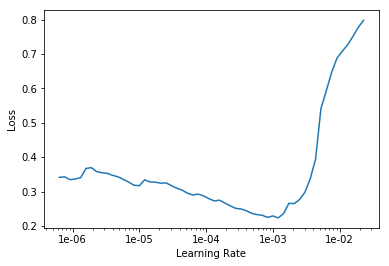

In [27]:
#plot du nouveau learn avec lr_find

# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [28]:
#re-train le model sur 2 cycles après avoir trouver le learning rate
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.313216,0.556998,0.157895,00:09
1,0.284176,0.562830,0.149123,00:09


In [0]:
#enregistrer la seconde version du model prenant en compte le lr_find sous le nom "stage-2"
learn.save('stage-2')

## **Interpretation**

In [0]:
#appeler le model précedement enregistré
learn.load('stage-2');

In [0]:
#créer la matrice de confusion
interp = ClassificationInterpretation.from_learner(learn)

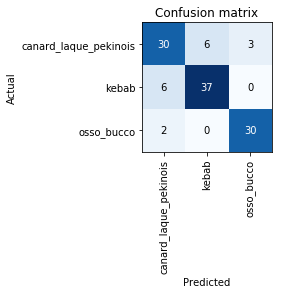

In [32]:
#ploter la matrice de confusion
interp.plot_confusion_matrix()

## Cleaning Up (ne pas faire tourner, ne marche que sur jupiter)
## Detecter les top_losses (images mal classées) du model qui diminuent ses perf, on peut ensuite les supp ou non

## Une version du Cleaning Up bientot dispo pour Colab

In [0]:
#certaines pertes (losses) ne sont pas du aux mauvaises performance de notre model
#elles sont du à des images du dataset qui n'ont rien a faire là 

In [0]:
#code ok pour Colab
#code qui copie les top_losses dans un nouveau fichier
#cela permet de voir quel sont les fichiers qui baissent les perf de notre model
#cela crée des duplicatas des images qui ont été mal classées

from fastai.widgets import *

cleaner_tuples = []
for ds_type in [DatasetType.Valid, DatasetType.Train]:
  ds, idxs = DatasetFormatter().from_toplosses(learn, n_imgs=30, ds_type=ds_type)
  cleaner_tuples.append((ds_type, ds, idxs))

import ntpath

top_loss_path = path/'top_losses/'
top_loss_path.mkdir(parents=True, exist_ok=True)
top_loss_filenames = set()

for ct in cleaner_tuples:
  ds_type = ct[0]
  ds = ct[1]
  idxs = ct[2]

  for idx in idxs:
    full_filepath = ds.x.items[idx]
    _, filename = ntpath.split(full_filepath)

    image_data = ds[idx][0]
    image_category = ds[idx][1]
    image_fullpath = top_loss_path/f'{image_category}_{filename}'
    image_data.save(image_fullpath)

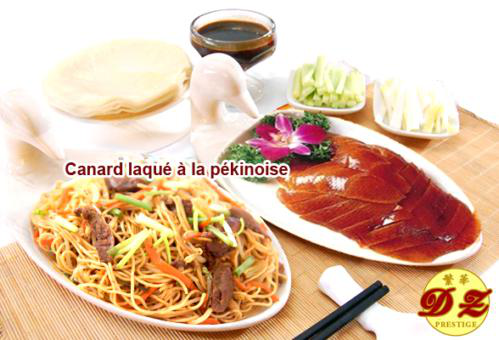

In [34]:
open_image(path/'canard_laque_pekinois'/'00000050.jpg')

## **Production**

In [0]:
#exporter le model sous un fichier .pkl
learn.export()

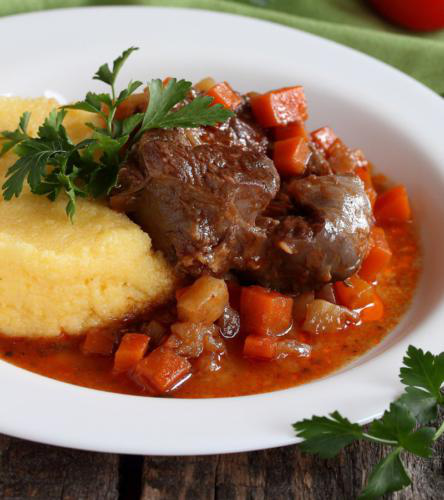

In [36]:
#ouvrir une image (peu import laquelle)
img = open_image(path/'osso_bucco'/'00000012.jpg')
img

In [0]:
#load_learner() va loader tout le path (fichier où nous travaillons) comportant notre export.pkl
learn = load_learner(path)

In [38]:
#faire un predict avec l'objet learn sur l'objet img en argument
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category osso_bucco